In [ ]:
%pip install catboost
%pip install xgboost
%pip install imblearn


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbPipeline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


1. EDA

1.1 Data exploration and cleaning

In [ ]:
# Создаем датафрейм:
df = pd.read_csv('/content/drive/MyDrive/bank_full.csv')

In [ ]:
# Смотрим заголовки
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [ ]:
# проверяем структуру данных:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [ ]:
# Смотрим сколько столбцов/полей:
df.shape

(45211, 17)

In [ ]:
# Смотрим какие есть значения в числовых колонках:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [ ]:
# Смотрим количество уникальных значений в каждой категорияльной колонке:
for col in df.select_dtypes(include='object').columns:
    print(col)
    print(df[col].unique())

job
['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']
marital
['married' 'single' 'divorced']
education
['tertiary' 'secondary' 'unknown' 'primary']
default
['no' 'yes']
housing
['yes' 'no']
loan
['no' 'yes']
contact
['unknown' 'cellular' 'telephone']
month
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']
poutcome
['unknown' 'failure' 'other' 'success']
y
['no' 'yes']


In [ ]:
# Поиск пропущенных значений в датасете:
features_na = [features for features in df.columns if df[features].isnull().sum() > 0]
for feature in features_na:
    print(feature, np.round(df[feature].isnull().mean(), 4),  ' % missing values')
else:
    print("No missing value found")

No missing value found


вывод: отсутсвуют данные с пропущенными значениями

In [ ]:
# Изучение фичей на количество одинаковых данных:
for column in df.columns:
    print(column,df[column].nunique())

age 77
job 12
marital 3
education 4
default 2
balance 7168
housing 2
loan 2
contact 3
day 31
month 12
duration 1573
campaign 48
pdays 559
previous 41
poutcome 4
y 2


In [ ]:
# Изучение категориальных фичей:
categorical_features=[feature for feature in df.columns if ((df[feature].dtypes=='O') & (feature not in ['deposit']))]
categorical_features

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome',
 'y']

In [ ]:
# Изучение категориальных данных на количество категорий:
for feature in categorical_features:
    print('Фича {} колчество категорий {}'.format(feature,len(df[feature].unique())))

Фича job колчество категорий 12
Фича marital колчество категорий 3
Фича education колчество категорий 4
Фича default колчество категорий 2
Фича housing колчество категорий 2
Фича loan колчество категорий 2
Фича contact колчество категорий 3
Фича month колчество категорий 12
Фича poutcome колчество категорий 4
Фича y колчество категорий 2


Вывод: Фича job и month имеют наибольшее количество категорий(12/12)

1.2 Data vizualization

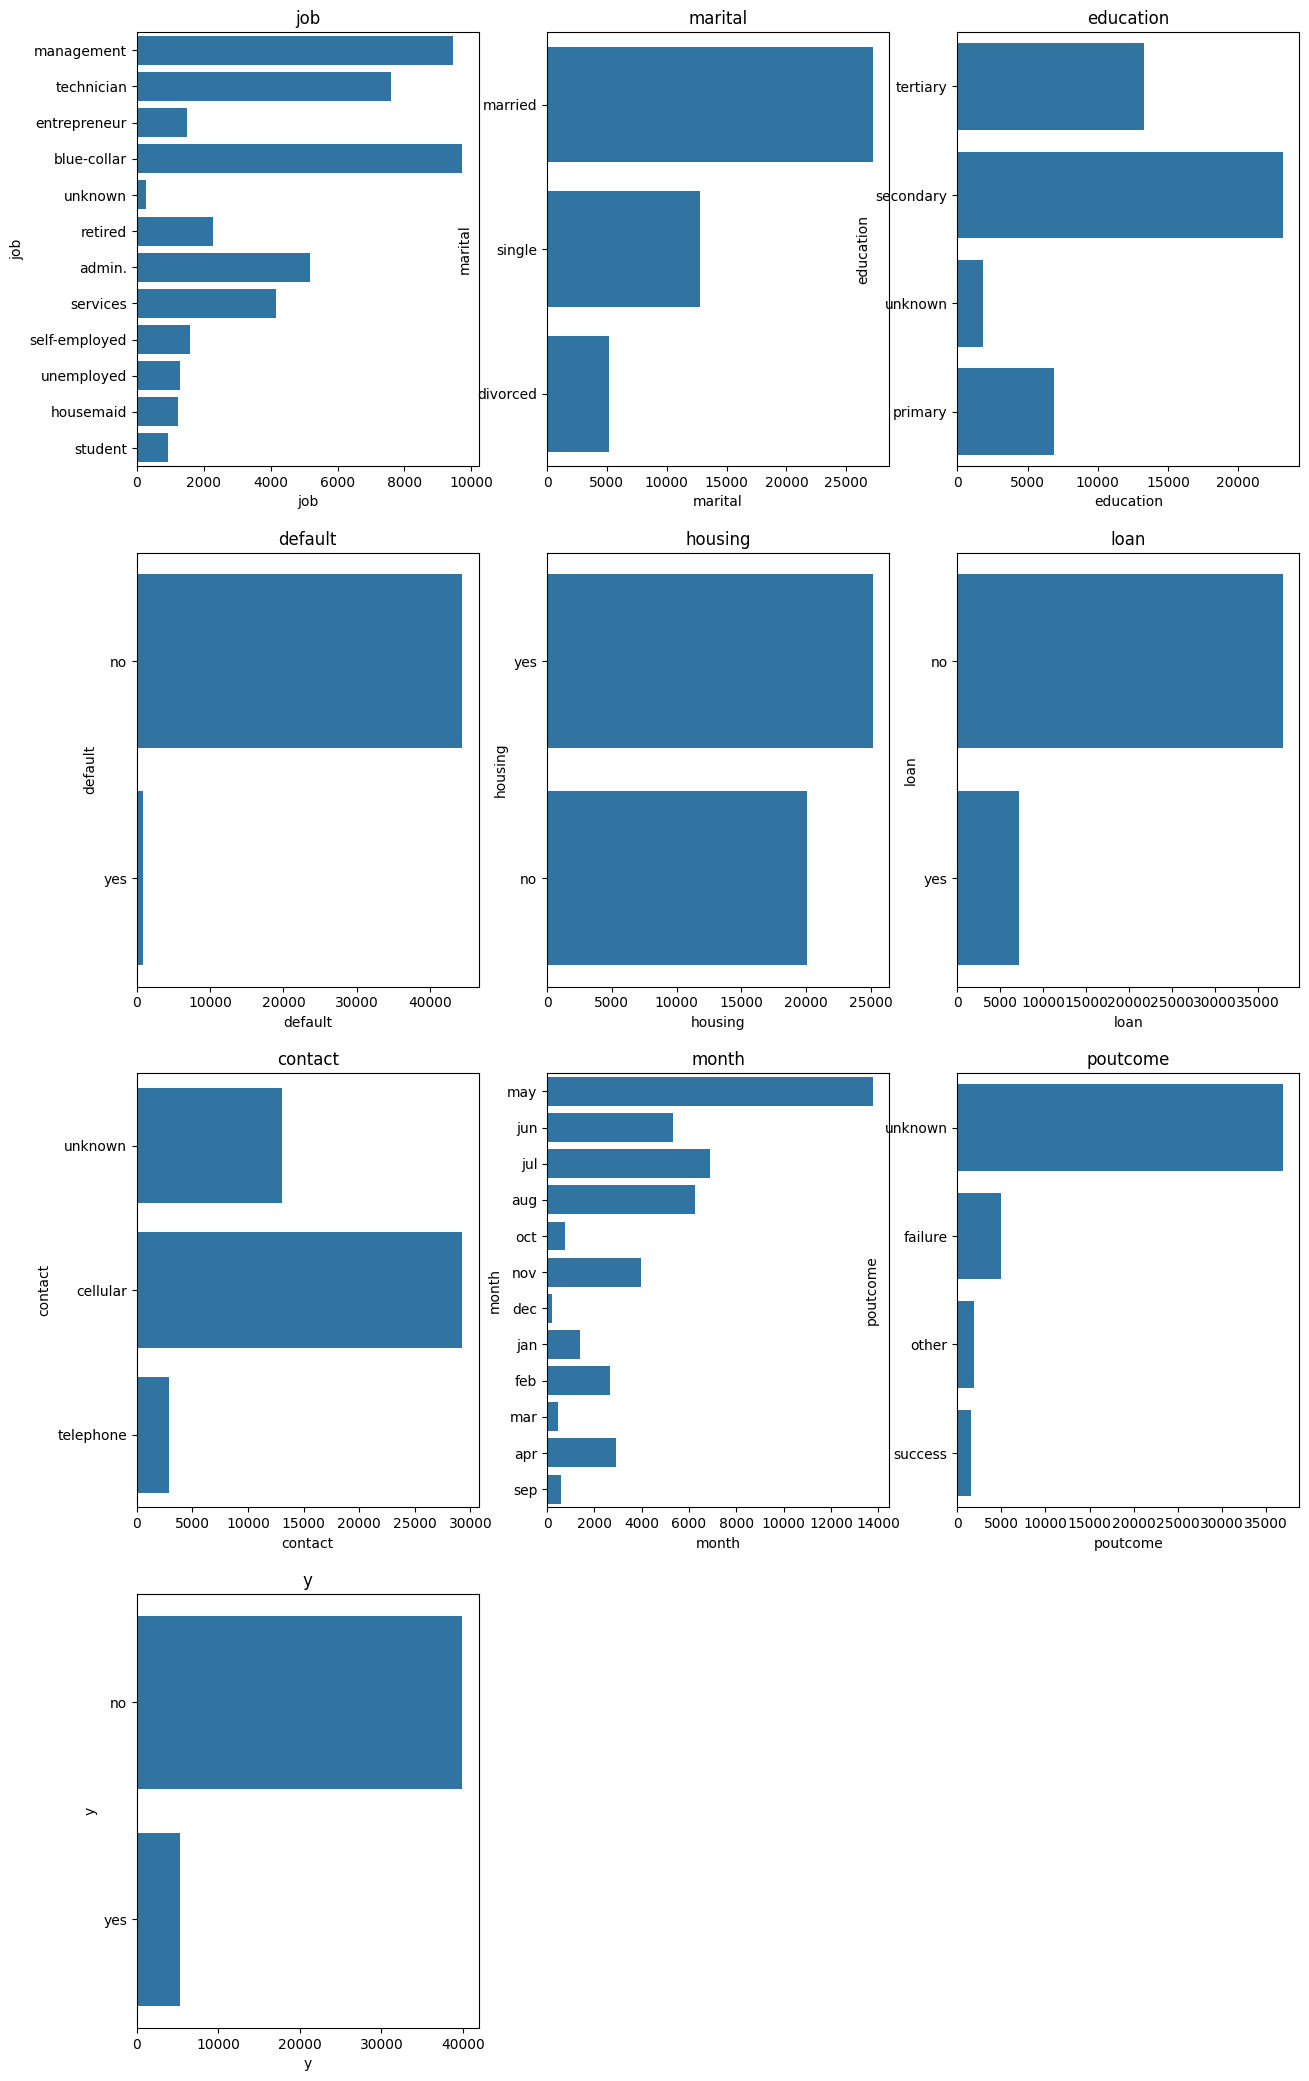

In [ ]:
# изучения категориальных данных:
plt.figure(figsize=(15,80), facecolor='white')
plotnumber =1
for categorical_feature in categorical_features:
    ax = plt.subplot(12,3,plotnumber)
    sns.countplot(y=categorical_feature,data=df)
    plt.xlabel(categorical_feature)
    plt.title(categorical_feature)
    plotnumber+=1
plt.show()

Выводы:
1. Менеджеров очень много, в то время студенов мало
2. Женатых/замужем преимущественно много
3. Людей со вторым(secondary) обучение большинство
4. люди с просрочкйо по кредиту очень мало
5. по месецам самый высокий показатель в мае, а самый низкий в декабре

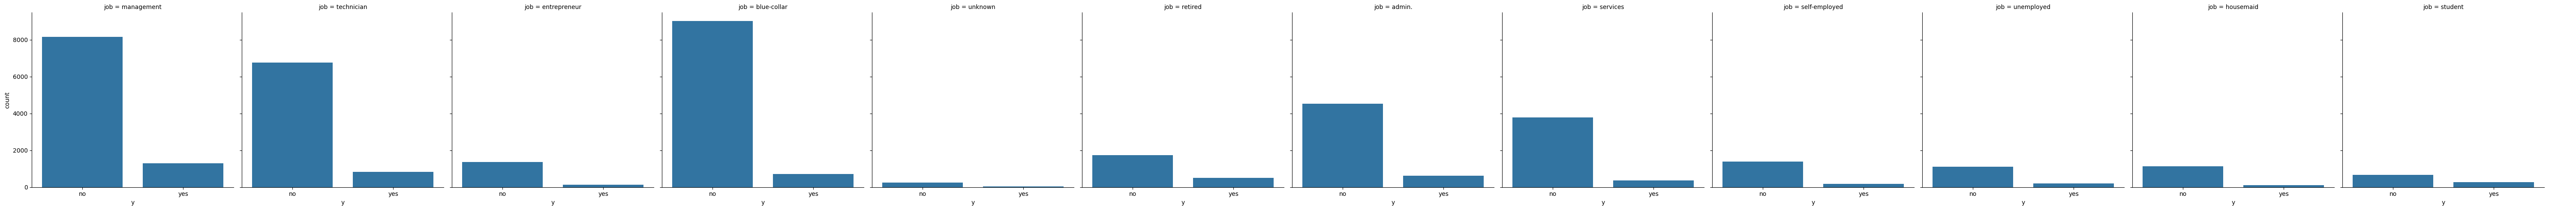

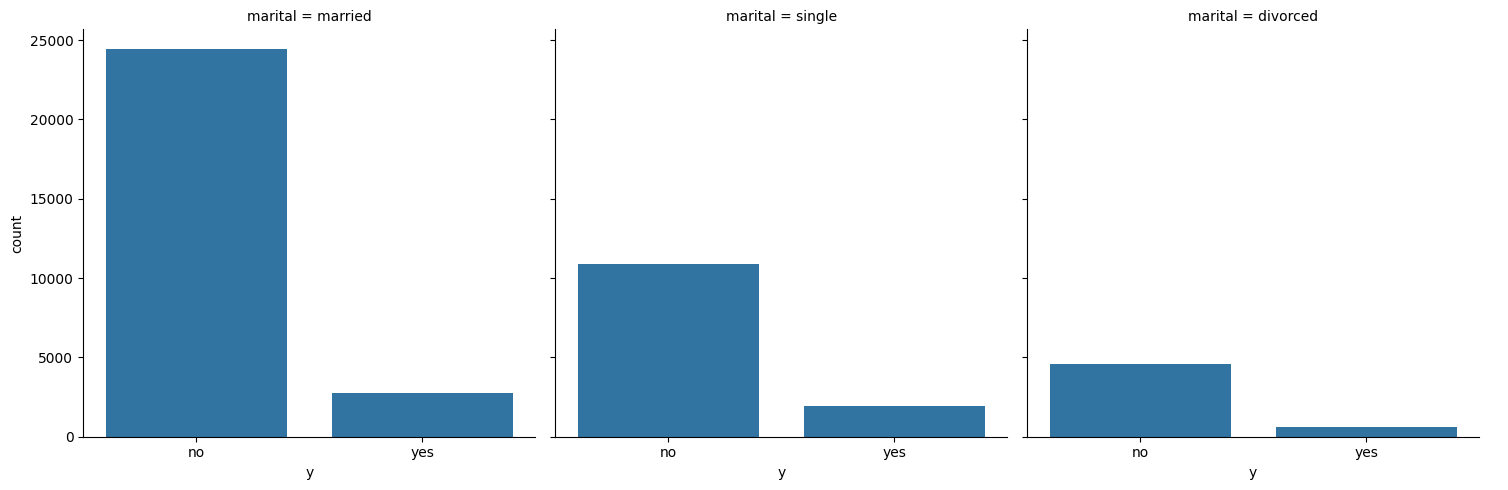

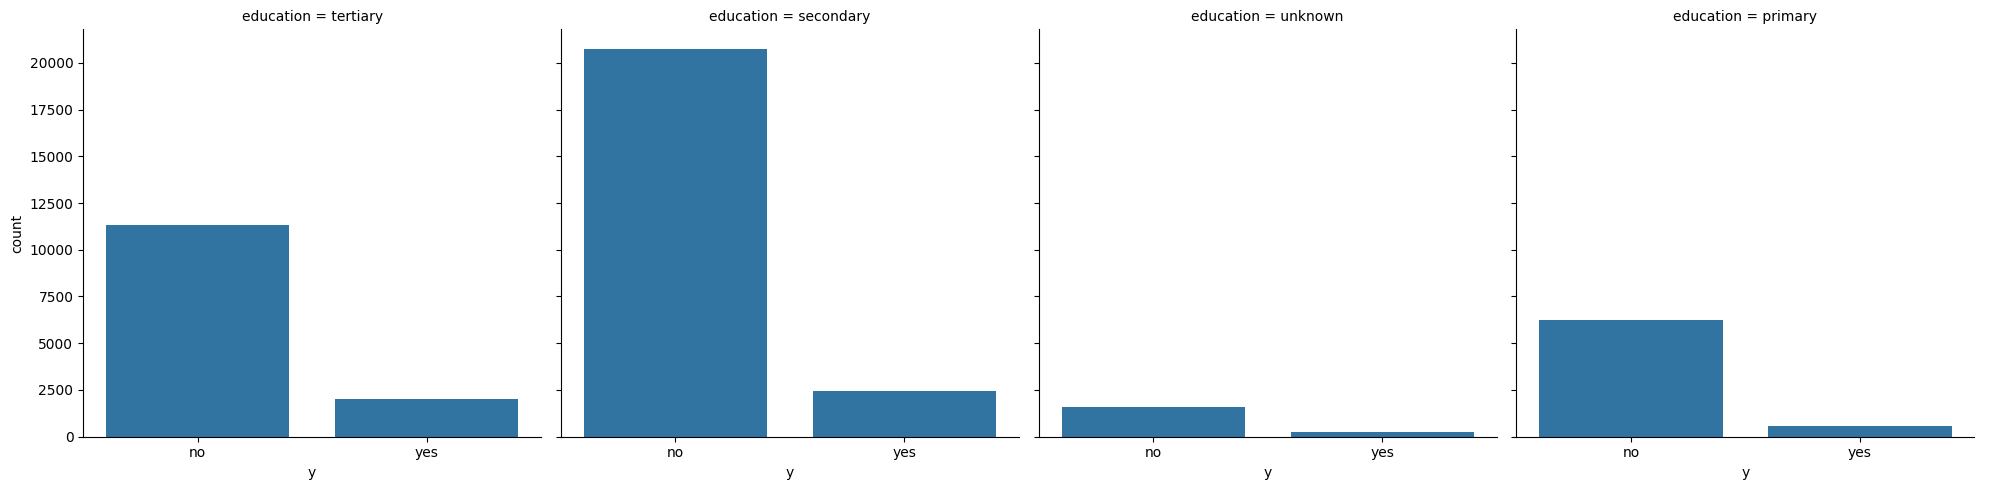

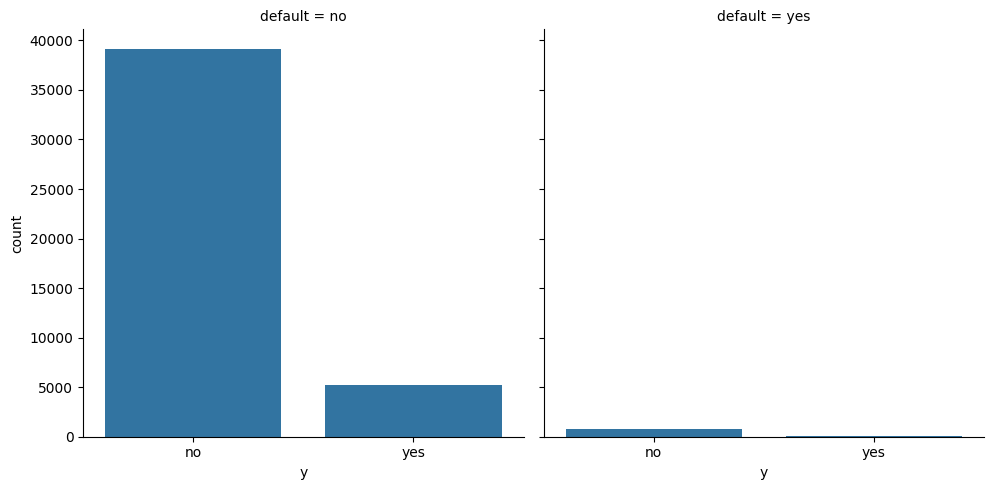

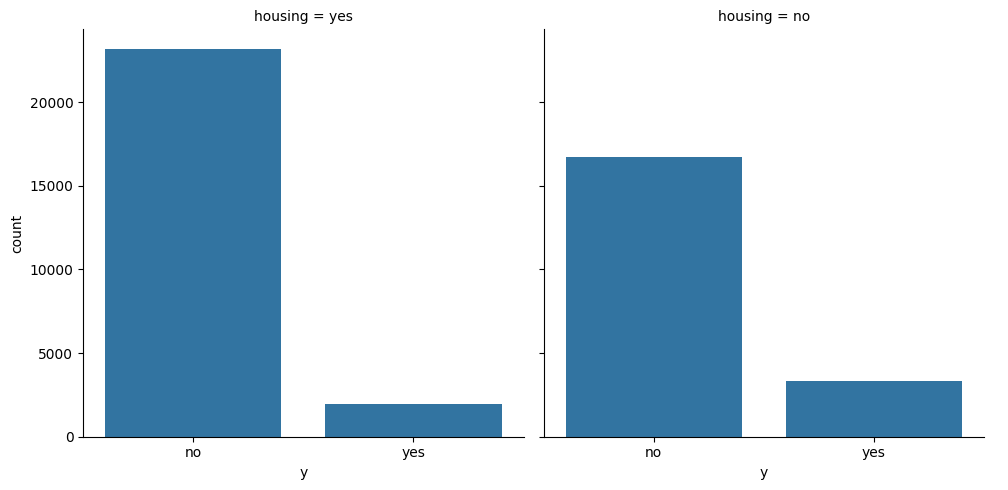

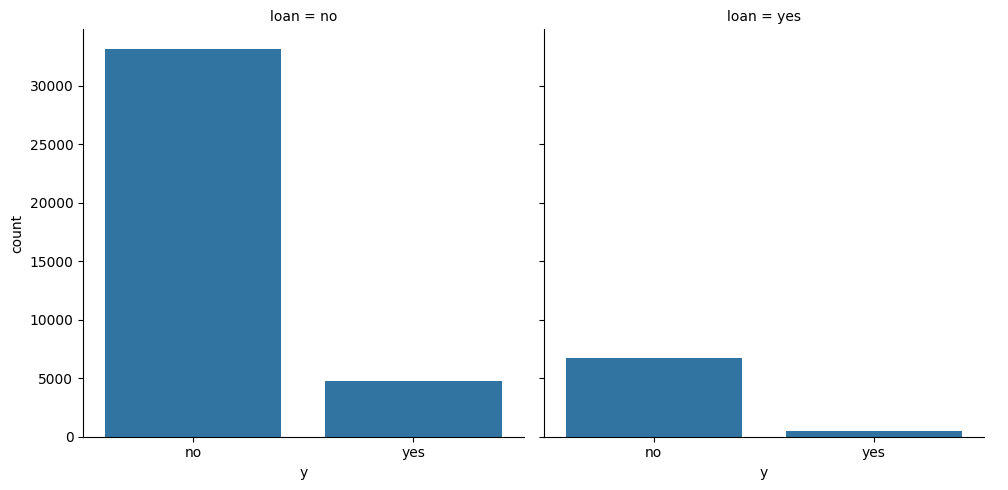

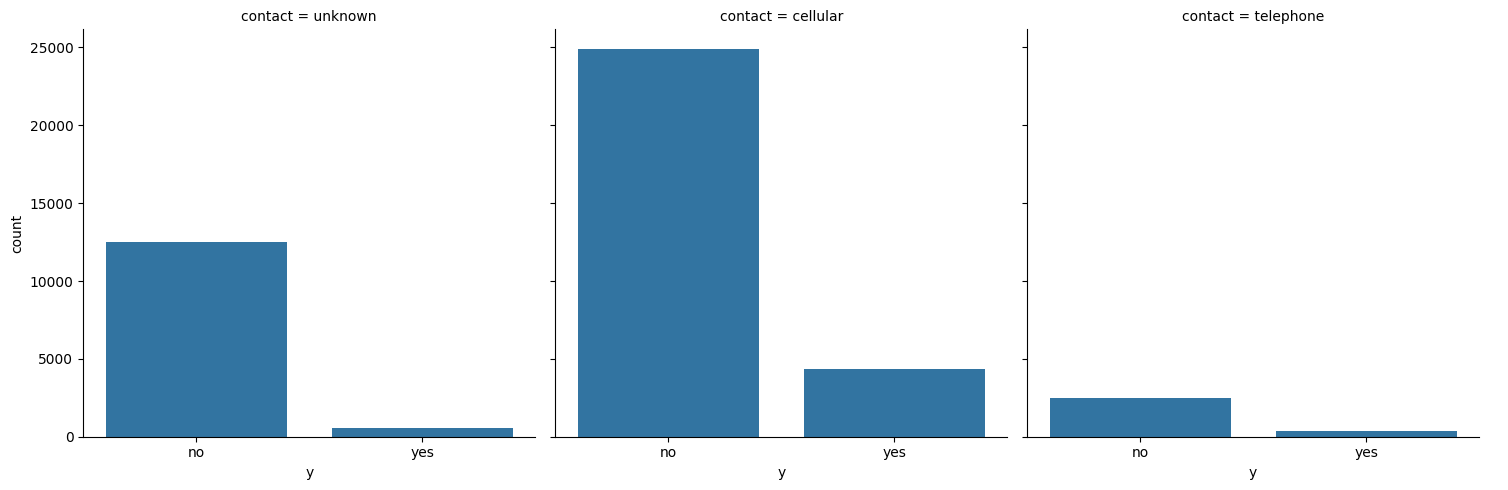

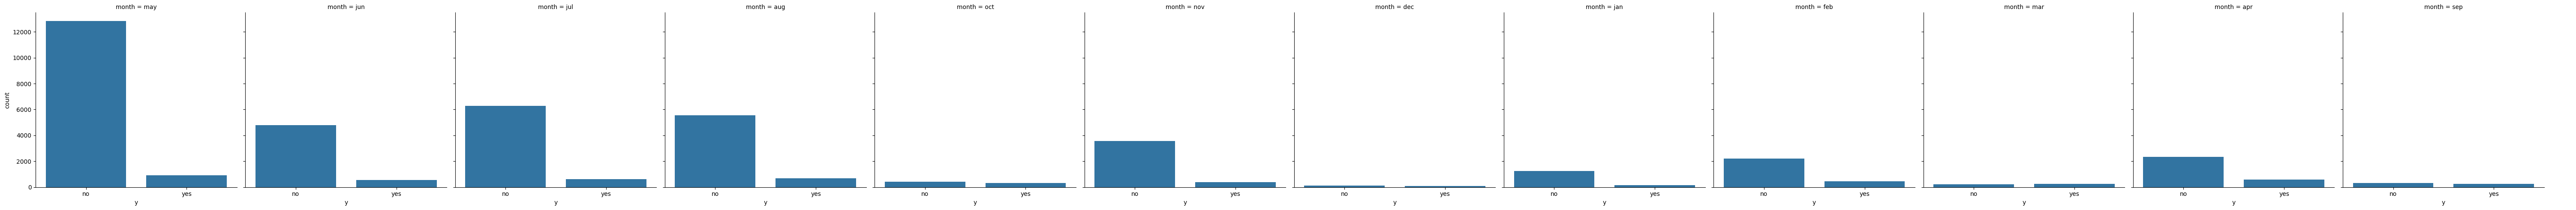

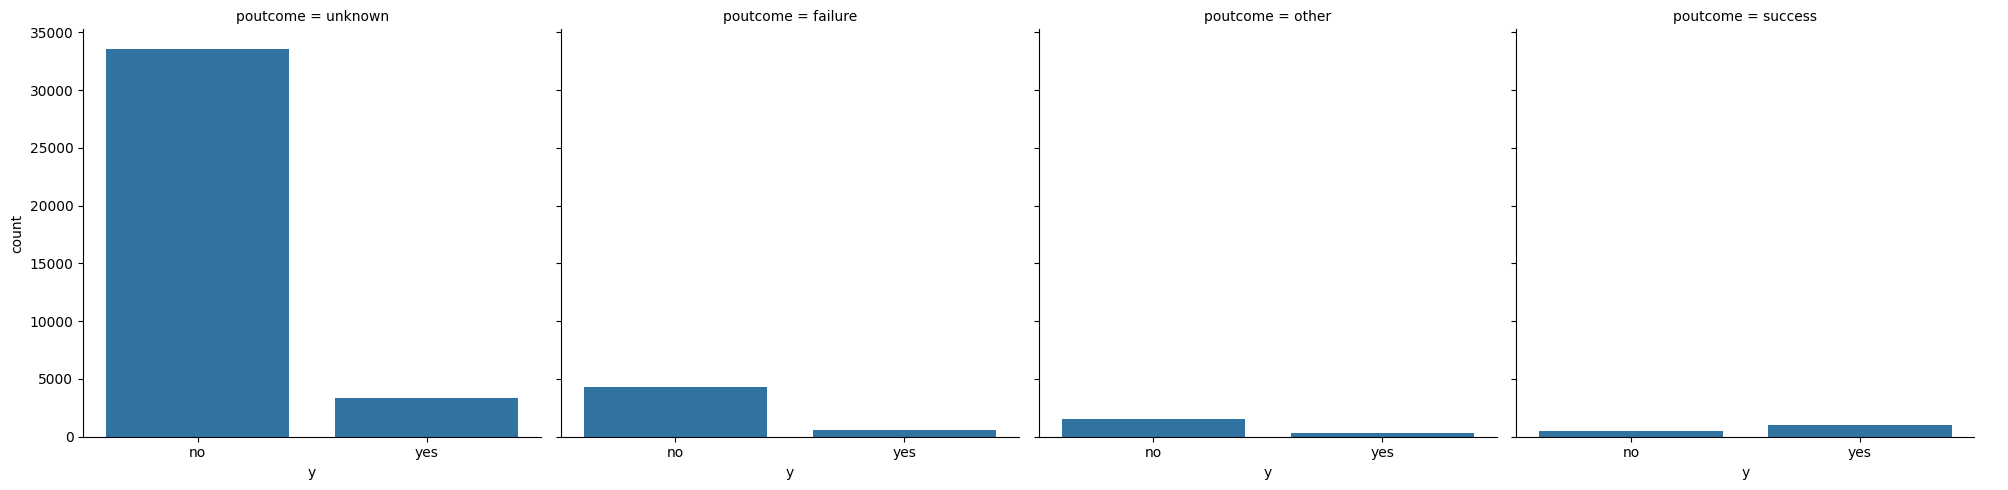

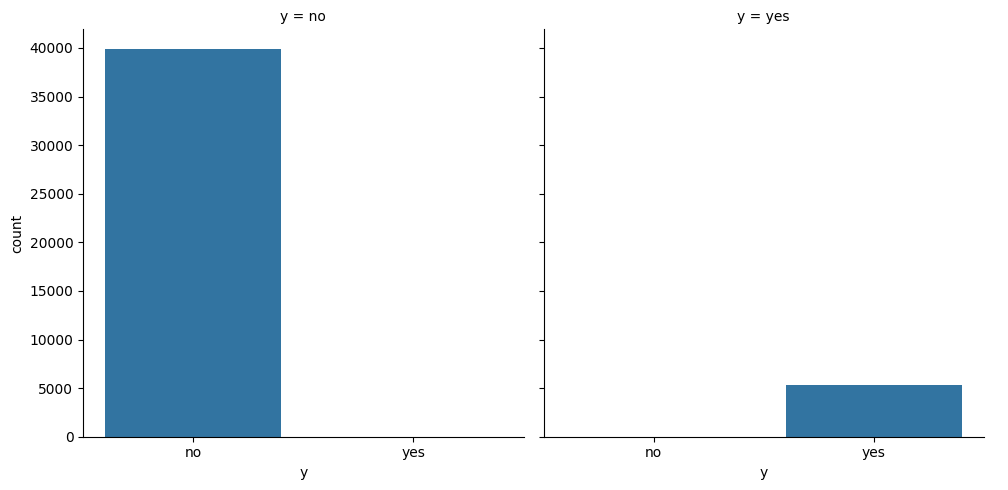

In [ ]:
# Определяем взаимосвязь между категориальными переменными и у:
for categorical_feature in categorical_features:
    sns.catplot(x='y', col=categorical_feature, kind='count', data= df)
plt.show()

In [ ]:
# Изучаем категориальные признаки на влияние открытия депозита:
for categorical_feature in categorical_features:
    print(df.groupby(['y',categorical_feature]).size())

y    job          
no   admin.           4540
     blue-collar      9024
     entrepreneur     1364
     housemaid        1131
     management       8157
     retired          1748
     self-employed    1392
     services         3785
     student           669
     technician       6757
     unemployed       1101
     unknown           254
yes  admin.            631
     blue-collar       708
     entrepreneur      123
     housemaid         109
     management       1301
     retired           516
     self-employed     187
     services          369
     student           269
     technician        840
     unemployed        202
     unknown            34
dtype: int64
y    marital 
no   divorced     4585
     married     24459
     single      10878
yes  divorced      622
     married      2755
     single       1912
dtype: int64
y    education
no   primary       6260
     secondary    20752
     tertiary     11305
     unknown       1605
yes  primary        591
     secondary     2

Выводы:
1. клиенты с кредитами и ипотекой меньше заинтересованы в открытии депозита;
2. в мае была максимальная заинтересованность, но открылось не так много депозитов с учетом заинтересованности. Хоть и в декабре было наименшее заинтересованнось, но по соотношению да/нет шансы открытия депозита высокие ~50%


In [ ]:
# Изучаем числовые значения:
numerical_features = [feature for feature in df.columns if ((df[feature].dtypes != 'O') & (feature not in ['deposit']))]
print('Number of numerical variables: ', len(numerical_features))
df[numerical_features].head()

Number of numerical variables:  7


,age,balance,day,duration,campaign,pdays,previous
0,58,2143,5,261,1,-1,0
1,44,29,5,151,1,-1,0
2,33,2,5,76,1,-1,0
3,47,1506,5,92,1,-1,0
4,33,1,5,198,1,-1,0


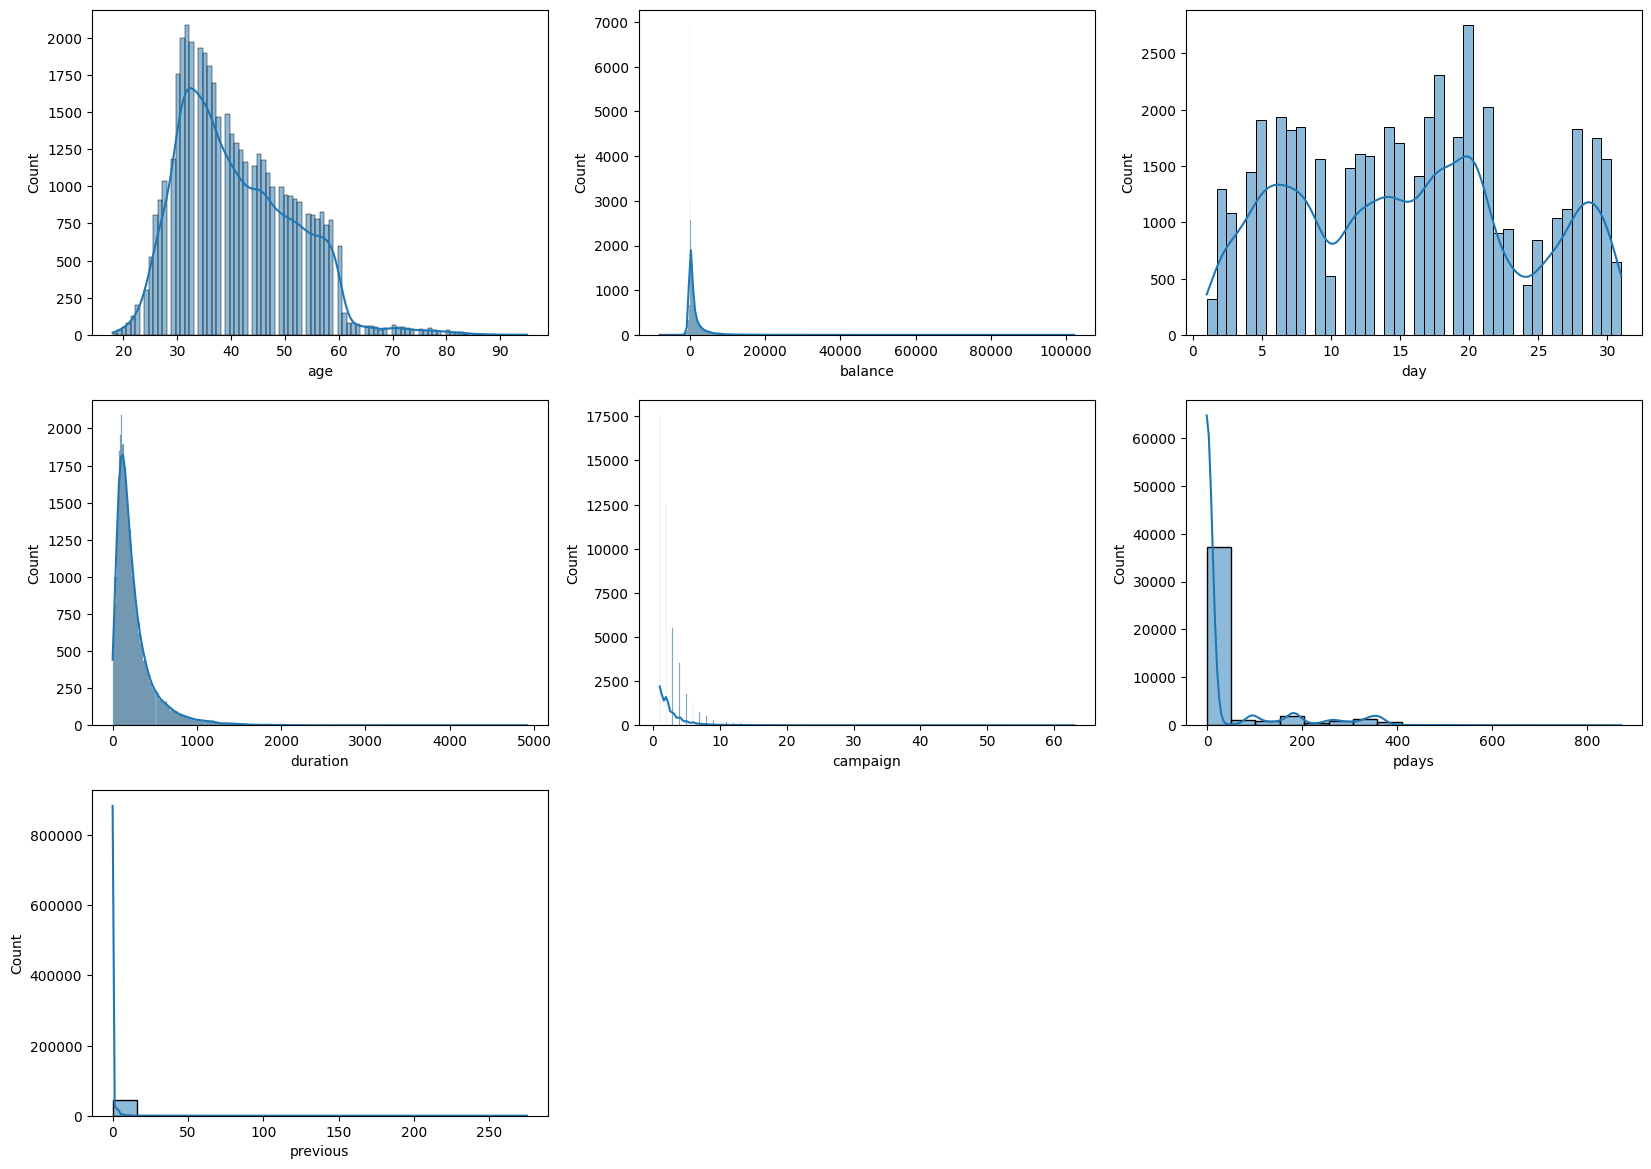

In [ ]:
# Строим графики для визуализации распределения и разброса значений по каждому столбцу:
plt.figure(figsize=(20,60), facecolor='white')
plotnumber =1
for continuous_feature in numerical_features:
    ax = plt.subplot(12,3,plotnumber)
    sns.histplot(df[continuous_feature], kde=True)
    plt.xlabel(continuous_feature)
    plotnumber+=1
plt.show()

Вывод: данные по age и day имеют нормальное распределение. В то время как остальные имеют большой разброс данных.          

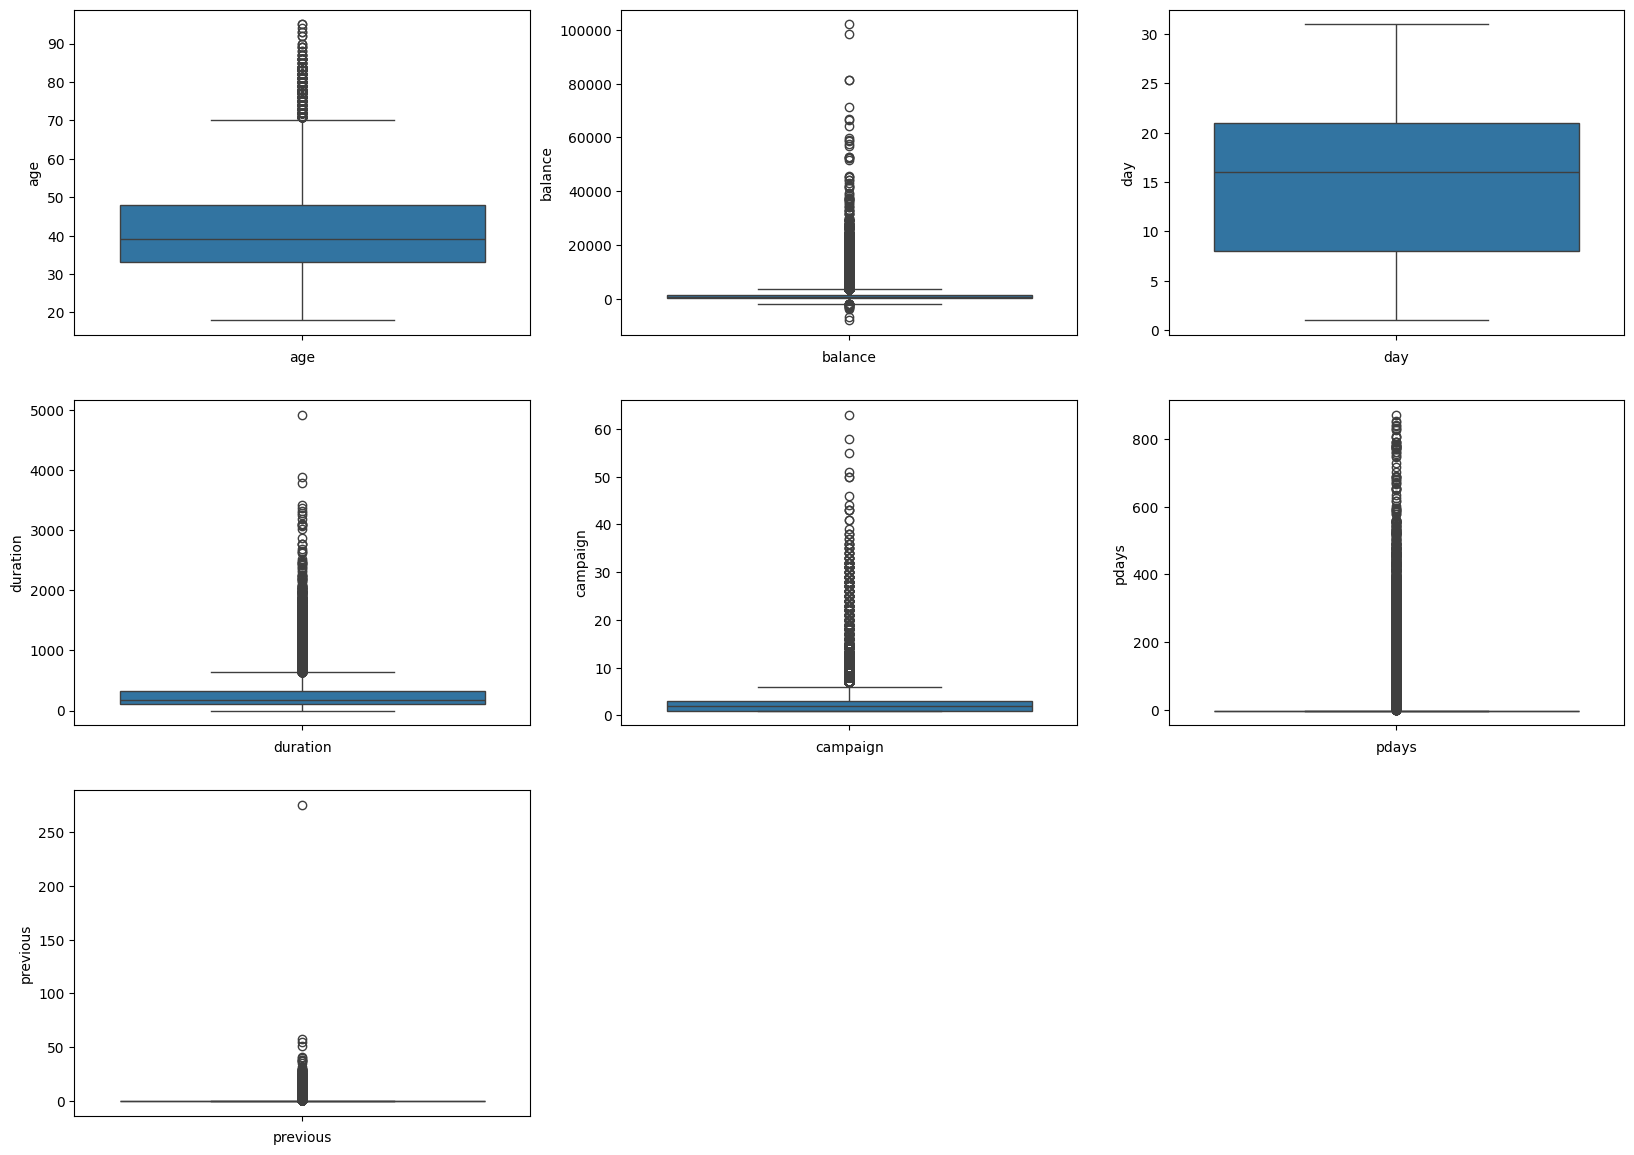

In [ ]:
# Строим box-plot для числовых признаков, для оценки распределение значений:
plt.figure(figsize=(20,60), facecolor='white')
plotnumber =1
for numerical_feature in numerical_features:
    ax = plt.subplot(12,3,plotnumber)
    sns.boxplot(df[numerical_feature])
    plt.xlabel(numerical_feature)
    plotnumber+=1
plt.show()

вывод: колонки age, balance, duration, compaign, pdays и previous имеют разброс данных

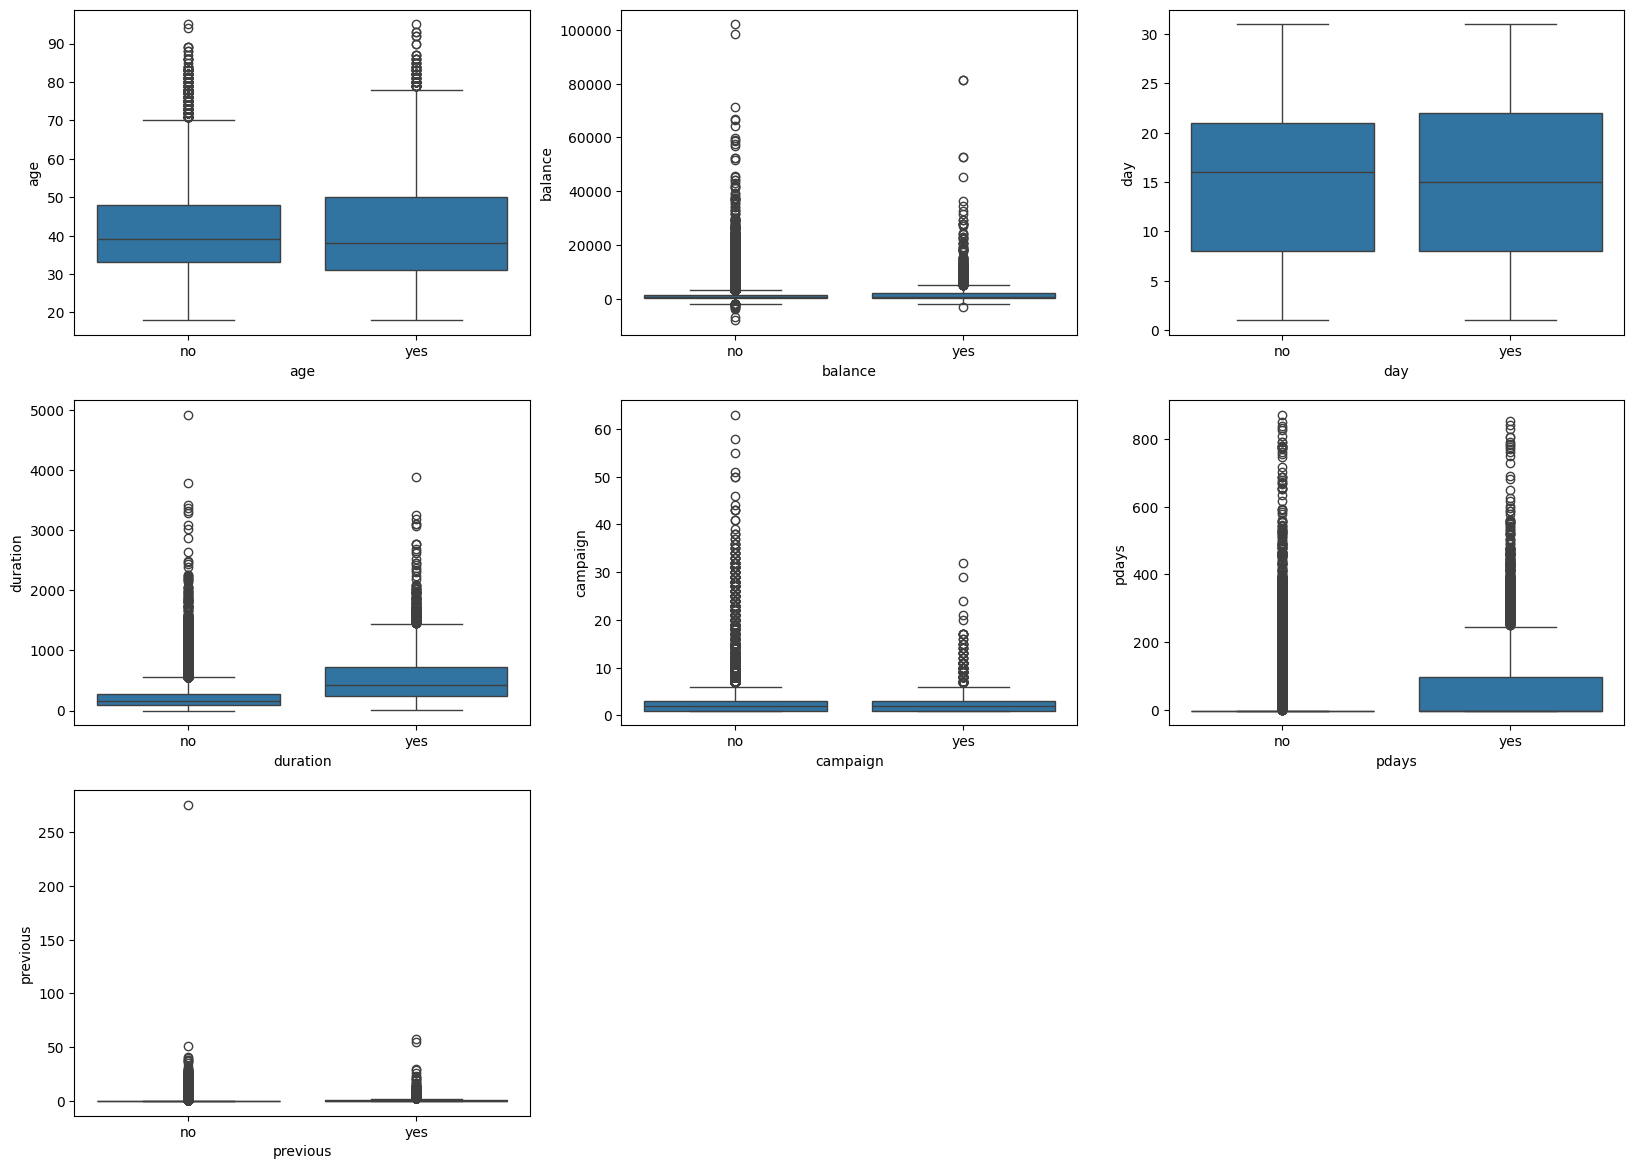

In [ ]:
# Строим boxplot-графики (ящики с усами) для каждого числового признака, чтобы визуально сравнить распределения значений для y = 0 и y = 1:
plt.figure(figsize=(20,60), facecolor='white')
plotnumber =1
for feature in numerical_features:
    ax = plt.subplot(12,3,plotnumber)
    sns.boxplot(x="y", y= df[feature], data=df)
    plt.xlabel(feature)
    plotnumber+=1
plt.show()

Вывод: Клиенты с большим значением duration имели больший интерес

1.3 Correlation analysis

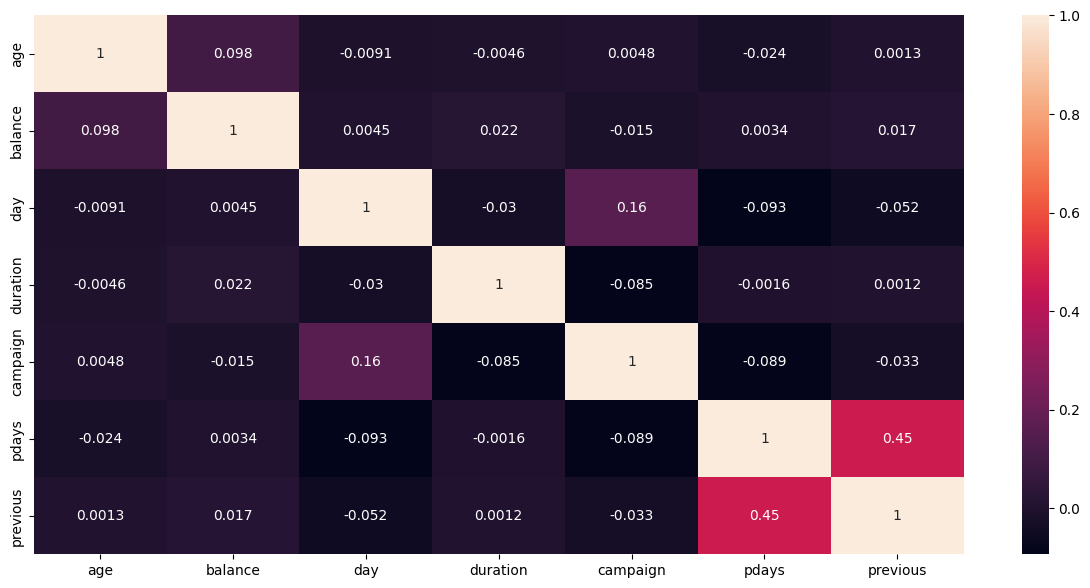

In [ ]:
# Изучаем корреляцию для числовых значений в датасете:
numerical_df = df.select_dtypes(include=np.number)
cor_mat = numerical_df.corr()
fig = plt.figure(figsize=(15,7))
sns.heatmap(cor_mat,annot=True)
plt.show()

Вывод:
Высоку корреляцию имеют признаки day<->pday, campain<->pdays, campain<->duration и day<->previous

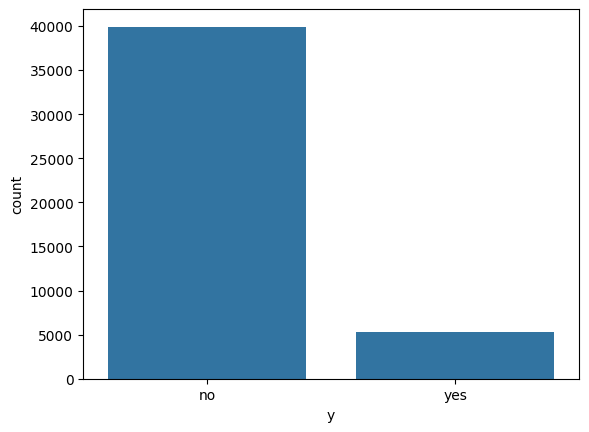

In [ ]:
# Выстраиваем график для изучения баланса значений у:
sns.countplot(x='y',data=df)
plt.show()

Вывод:
Количество yes/no довольно разнятся(примерно 1 к 8), поэтому необходимо учитывать это при выборе алгоритмов. Можно было усреднить значение путем добавление положительных значений или уменьшением отрицательных с помощью smote, но я поизучив варианты решил использовать параметры в алгоритмах (учитывать дисбаланс указав в параметрах)

2. Data processing (Предобработка данных)

In [ ]:
# Копируем датасет так как будем его изменять в дальнейшем:
df2=df.copy()

In [ ]:
df2.groupby(['y','pdays']).size()

y    pdays
no   -1       33570
      1           9
      2          35
      3           1
      4           1
              ...  
yes   804         1
      805         1
      828         1
      842         1
      854         1
Length: 914, dtype: int64

In [ ]:
# Удаляем pdays
df2.drop(['pdays'],axis=1, inplace=True)

In [ ]:
# группируем данные у и campaing для наблюдения взаимосвязи значений:
df2.groupby(['y','campaign'],sort=True)['campaign'].count()

y    campaign
no   1           14983
     2           11104
     3            4903
     4            3205
     5            1625
                 ...  
yes  20              1
     21              1
     24              1
     29              1
     32              1
Name: campaign, Length: 70, dtype: int64

In [ ]:
# Изучая визуализацию и группировку по campaing cоздадим df3 и ставим ограничение значений до 33 звонков для улучшения разброса данных и для исключения экстримальных значений:
df3 = df2[df2['campaign'] < 33]

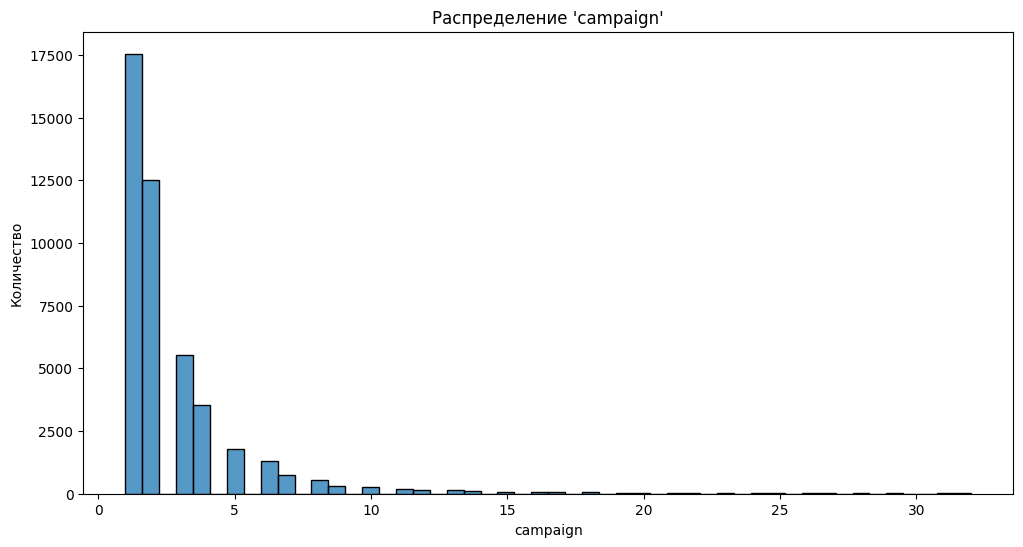

In [ ]:
# Визуализация распределения значений campaign:
plt.figure(figsize=(12, 6))
sns.histplot(df3['campaign'], bins=50, kde=False)
plt.title("Распределение 'campaign'")
plt.xlabel("campaign")
plt.ylabel("Количество")
plt.show()

In [ ]:
# группируем данные у и previus для наблюдения взаимосвязи значений:
df3.groupby(['y','previous'],sort=True)['previous'].count()

y    previous
no   0           33532
     1            2189
     2            1650
     3             848
     4             543
                 ...  
yes  26              1
     29              1
     30              1
     55              1
     58              1
Name: previous, Length: 66, dtype: int64

In [ ]:
# Изучаем значения previus:
df3['previous'].value_counts().sort_index()

,count
previous,
0,36916
1,2772
2,2106
3,1142
4,714
5,459
6,277
7,205
8,129


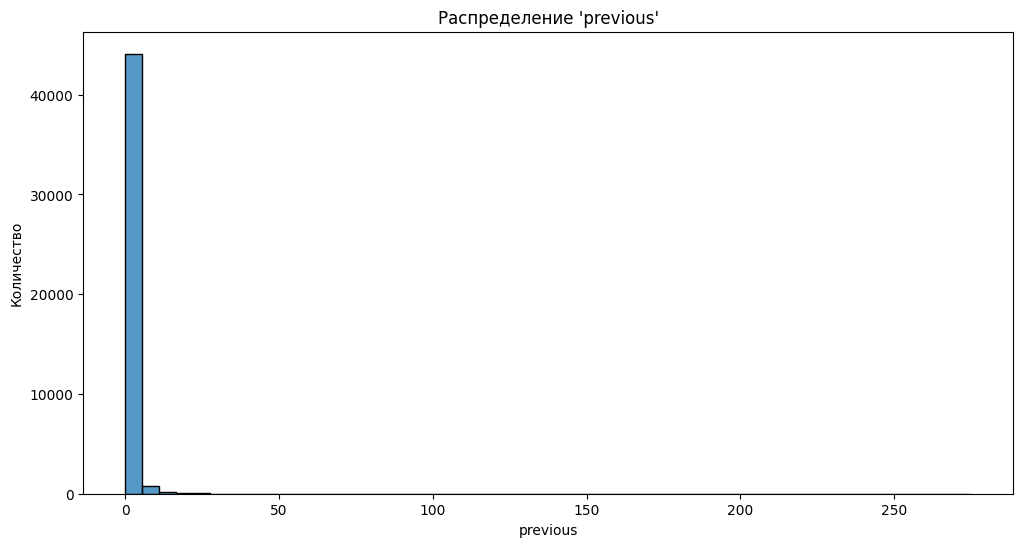

In [ ]:
# Визуализация
plt.figure(figsize=(12, 6))
sns.histplot(df3['previous'], bins=50, kde=False)
plt.title("Распределение 'previous'")
plt.xlabel("previous")
plt.ylabel("Количество")
plt.show()

In [ ]:
# Согласно визуализации и value.count основные значения расположены между 0 и 30, поэтому удаляем аномальны значений больше 30:
df4 = df3[df3['previous'] < 31]

In [ ]:
# Преобразуем категориальные значения в числовые:
cat_columns = ['job', 'marital', 'education', 'contact', 'month', 'poutcome']
for col in  cat_columns:
    df4 = pd.concat([df4.drop(col, axis=1),pd.get_dummies(df4[col], prefix=col, prefix_sep='_',drop_first=True, dummy_na=False)], axis=1)

In [ ]:
# Преобразуем бинарные признаки yes/no на числовые 0/1:
bool_columns = ['default', 'y']
for col in  bool_columns:
    df4[col+'_new']=df4[col].apply(lambda x : 1 if x == 'yes' else 0)
    df4.drop(col, axis=1, inplace=True)

In [ ]:
# Удаляем столбцы 'housing', 'loan' во избежания дублирования и ошибок:
df4.drop(columns=['housing', 'loan'], inplace=True)

In [ ]:
# Смотрим как преобразовался наш датасет, чтобы видеть все колонки использовал pd.set_options:
pd.set_option('display.max_columns', 100)
df4.head()

,age,balance,day,duration,campaign,previous,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,contact_telephone,contact_unknown,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown,default_new,y_new
0,58,2143,5,261,1,0,False,False,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,0,0
1,44,29,5,151,1,0,False,False,False,False,False,False,False,False,True,False,False,False,True,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,0,0
2,33,2,5,76,1,0,False,True,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,0,0
3,47,1506,5,92,1,0,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,0,0
4,33,1,5,198,1,0,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,True,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,0,0


Вывод: убеждаемся что нет дублирующих колонок и все данные числовые/логические

In [ ]:
# Удаляем y и Разделяем датасет на тестовый и тренировочный по стандарту 20/80:
X = df4.drop(['y_new'],axis=1)
y = df4['y_new']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0)

In [ ]:
# Проверяем правильно ли разделились данные:
len(X_train)

36128

In [ ]:
len(X_test)

9033

Выбор модели

3. Model Building (Построение моделей)

In [ ]:
# Выбирая меджу видами Scaler, решил использовать StandartScaler так как он универсальный вариант:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

3.1 Logistic Regression

Confusion Matrix:
[[6694 1256]
 [ 216  867]]


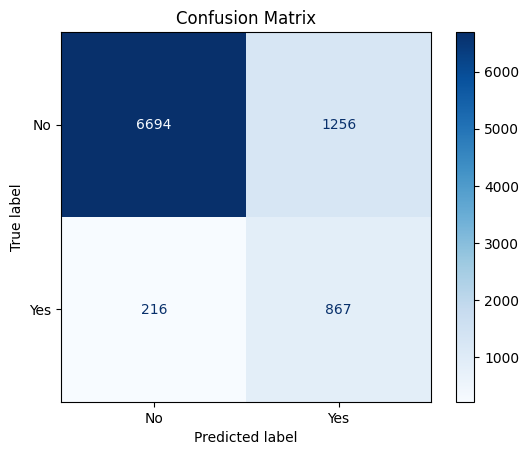


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.84      0.90      7950
           1       0.41      0.80      0.54      1083

    accuracy                           0.84      9033
   macro avg       0.69      0.82      0.72      9033
weighted avg       0.90      0.84      0.86      9033

Accuracy: 0.84
Precision: 0.41
Recall: 0.80
F1 Score: 0.54


In [ ]:
log_reg = LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced')
log_reg.fit(X_train_scaled, y_train)

y_pred_lr = log_reg.predict(X_test_scaled)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_lr)
print("Confusion Matrix:")
print(conf_matrix)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=['No', 'Yes'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_lr):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_lr):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred_lr):.2f}")

Вывод: С помошью class_weight='balanced' удалось улучшить результат recall от 0.4 до 0.8. Recall нам очень важен так как нам нужно минимизировать пропуск положительные результатов. Если модель пропускает заинтересованных людей, банк теряет деньги.

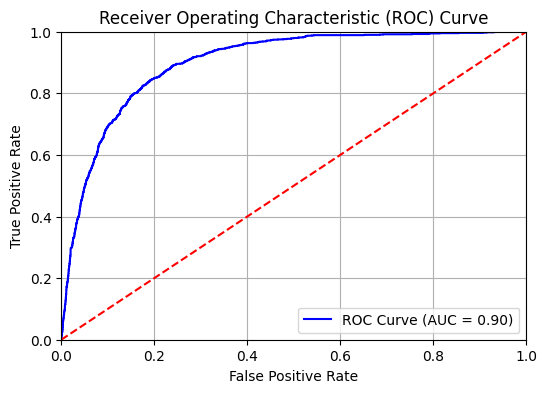

In [ ]:
# ROC AUC
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(model, X_test, y_test):
    y_prob = model.predict_proba(X_test)[:, 1]

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

plot_roc_curve(log_reg, X_test_scaled, y_test)

In [ ]:
# Grid Search
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
}

grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='recall')
grid_search.fit(X_train_scaled, y_train)

# Best Parameters
print("\nBest Parameters from GridSearchCV:")
print(grid_search.best_params_)
print(f"Best Cross-Validation Score: {grid_search.best_score_:.2f}")


Best Parameters from GridSearchCV:
{'C': 0.01, 'penalty': 'l2'}
Best Cross-Validation Score: 0.81


In [ ]:
# Random Search
from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(log_reg, param_grid, n_iter=7, cv=10, random_state=42, scoring='recall' )
random_search.fit(X_train_scaled, y_train)

print("\nBest Parameters from RandomizedSearchCV:")
print(random_search.best_params_)
print(f"Best Cross-Validation Score: {random_search.best_score_:.2f}")


Best Parameters from RandomizedSearchCV:
{'penalty': 'l2', 'C': 0.01}
Best Cross-Validation Score: 0.81


In [ ]:
from sklearn.model_selection import cross_val_score

best_lr_classifier = grid_search.best_estimator_
cv_scores = cross_val_score(best_lr_classifier, X_train_scaled, y_train, cv=5, scoring='recall')

# Cross-validation scores
print("Cross-Validation AUC Scores:", cv_scores)
print(f"Mean Cross-Validation AUC: {cv_scores.mean():.2f}")

Cross-Validation AUC Scores: [0.81688466 0.80261593 0.81093936 0.825      0.79310345]
Mean Cross-Validation AUC: 0.81


In [ ]:
# Feature importance
feature_names = X_train.columns

coefficients = best_lr_classifier.coef_[0]

lr_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance (Coefficient)': coefficients
}).sort_values(by='Importance (Coefficient)', key=abs, ascending=False)

lr_importance_df.reset_index(drop=True, inplace=True)
lr_importance_df

,Feature,Importance (Coefficient)
0,duration,1.419755
1,contact_unknown,-0.744079
2,poutcome_success,0.461594
3,month_jul,-0.357212
4,month_may,-0.340516
5,campaign,-0.282837
6,month_nov,-0.256940
7,job_blue-collar,-0.215079
8,month_mar,0.203998
9,month_aug,-0.192422


Вывод: В логистической регресии:
*   Accuracy: 0.84
*   Precision: 0.41
*   Recall: 0.80
*   F1 Score: 0.54
*   по всем методам поиска гиперпараметров 0.81



3.2 Decision Tree

Confusion Matrix:
[[7424  526]
 [ 602  481]]


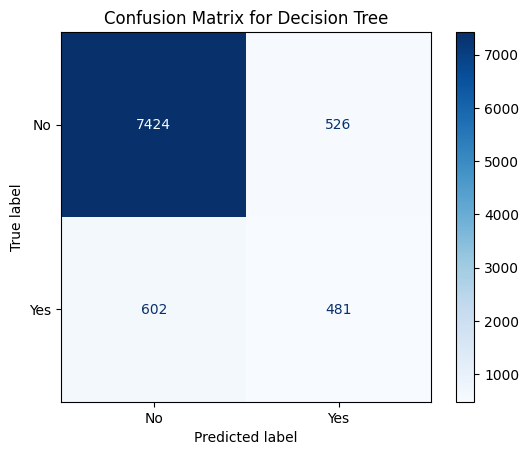


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.93      7950
           1       0.48      0.44      0.46      1083

    accuracy                           0.88      9033
   macro avg       0.70      0.69      0.69      9033
weighted avg       0.87      0.88      0.87      9033

Accuracy: 0.88
Precision: 0.48
Recall: 0.44
F1 Score: 0.46


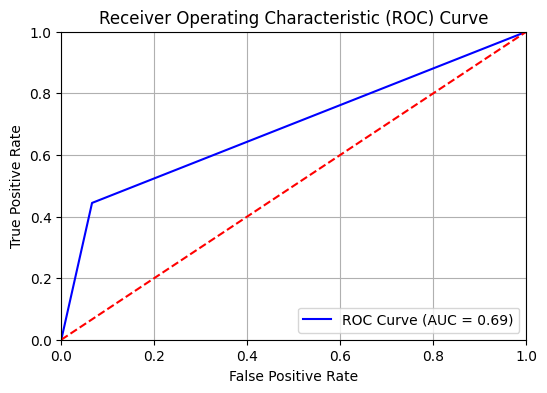

In [ ]:
dt_classifier = DecisionTreeClassifier(class_weight='balanced', random_state=42)
dt_classifier.fit(X_train_scaled, y_train)

y_pred_dt = dt_classifier.predict(X_test_scaled)

# Confusion Matrix
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
print("Confusion Matrix:")
print(conf_matrix_dt)

disp_dt = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_dt,
                                  display_labels=['No', 'Yes'])
disp_dt.plot(cmap='Blues')
plt.title('Confusion Matrix for Decision Tree')
plt.show()

# Results
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt))

print(f"Accuracy: {accuracy_score(y_test, y_pred_dt):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_dt):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_dt):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred_dt):.2f}")

plot_roc_curve(dt_classifier, X_test_scaled, y_test)

In [ ]:
# GridSearch
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Set up GridSearchCV
grid_search_dt = GridSearchCV(estimator=dt_classifier,
                           param_grid=param_grid,
                           cv=5,
                           n_jobs=-1,
                           scoring='recall')

# Fit the model
grid_search_dt.fit(X_train_scaled, y_train)

# Best Parameters
print("\nBest Parameters from GridSearchCV:")
print(grid_search_dt.best_params_)
print(f"Best Cross-Validation Score: {grid_search_dt.best_score_:.2f}")

print("Best Parameters:", grid_search_dt.best_params_)


Best Parameters from GridSearchCV:
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}
Best Cross-Validation Score: 0.80
Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}


In [ ]:
# Cross-validation
best_dt_classifier = grid_search_dt.best_estimator_
cv_scores = cross_val_score(best_dt_classifier, X_train_scaled, y_train, cv=5, scoring='recall')

# Print cross-validation scores
print("Cross-Validation AUC Scores:", cv_scores)
print(f"Mean Cross-Validation AUC: {cv_scores.mean():.2f}")

Cross-Validation AUC Scores: [0.80499405 0.80380499 0.82877527 0.82738095 0.75267539]
Mean Cross-Validation AUC: 0.80


In [ ]:
# Feature Importance

def get_feature_importance(model, feature_names):
    importance = model.feature_importances_

    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values(by='Importance', ascending=False)

    importance_df.reset_index(drop=True, inplace=True)
    return importance_df


dt_importance_df = get_feature_importance(best_dt_classifier, X_train.columns)
dt_importance_df

,Feature,Importance
0,duration,0.497654
1,poutcome_success,0.132271
2,contact_unknown,0.119182
3,age,0.038514
4,month_mar,0.038406
5,month_oct,0.036965
6,balance,0.023771
7,month_jun,0.022810
8,day,0.020004
9,marital_single,0.010486


Вывод: В Desigion tree:
*   Accuracy: 0.88
*   Precision: 0.48
*   Recall: 0.44
*   F1 Score: 0.46
*   по всем методам поиска гиперпараметров 0.80


3.3 Random Forest

Confusion Matrix:
[[7760  190]
 [ 741  342]]


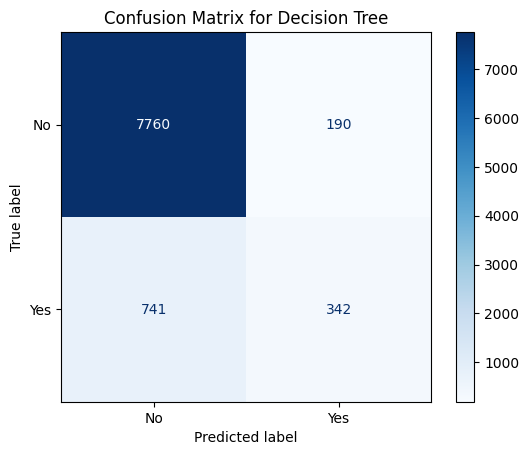


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      7950
           1       0.64      0.32      0.42      1083

    accuracy                           0.90      9033
   macro avg       0.78      0.65      0.68      9033
weighted avg       0.88      0.90      0.88      9033

Accuracy: 0.90
Precision: 0.64
Recall: 0.32
F1 Score: 0.42


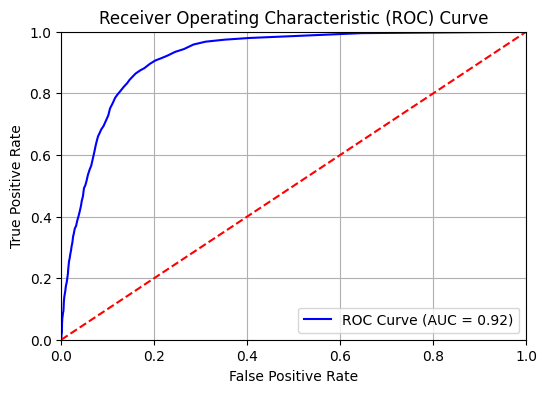

In [ ]:
# Model Evaluation
rf_classifier = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_classifier.fit(X_train_scaled, y_train)

y_pred_rf = rf_classifier.predict(X_test_scaled)

# Confusion Matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix:")
print(conf_matrix_rf)

disp_rf = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_rf,
                                  display_labels=['No', 'Yes'])
disp_rf.plot(cmap='Blues')
plt.title('Confusion Matrix for Decision Tree')
plt.show()

# Results
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_rf):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_rf):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred_rf):.2f}")

plot_roc_curve(rf_classifier, X_test_scaled, y_test)

In [ ]:
# Random Search
from sklearn.model_selection import RandomizedSearchCV

rf_param_grid = {
    'n_estimators': [20, 50, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

random_search_rf = RandomizedSearchCV(rf_classifier, rf_param_grid, n_iter=5, cv=8, random_state=42, scoring='recall')
random_search_rf.fit(X_train_scaled, y_train)

print("\nBest Parameters from RandomizedSearchCV:")
print(random_search_rf.best_params_)
print(f"Best Cross-Validation Score: {random_search_rf.best_score_:.2f}")


Best Parameters from RandomizedSearchCV:
{'n_estimators': 20, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 10, 'criterion': 'entropy'}
Best Cross-Validation Score: 0.84


In [ ]:
# Cross-validation
best_rf_classifier = random_search_rf.best_estimator_
cv_scores = cross_val_score(best_rf_classifier, X_train_scaled, y_train, cv=5, scoring='recall')

# Print cross-validation scores
print("Cross-Validation AUC Scores:", cv_scores)
print(f"Mean Cross-Validation AUC: {cv_scores.mean():.2f}")

Cross-Validation AUC Scores: [0.85136742 0.8156956  0.81212842 0.84642857 0.81926278]
Mean Cross-Validation AUC: 0.83


In [ ]:
best_rf_classifier

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=10, min_samples_split=5, n_estimators=20,
                       random_state=42)

In [ ]:
# Feature Importance

rf_importance_df = get_feature_importance(best_rf_classifier, X_train.columns)
rf_importance_df

,Feature,Importance
0,duration,0.485544
1,poutcome_success,0.085802
2,contact_unknown,0.062414
3,age,0.043548
4,previous,0.040343
5,balance,0.036238
6,day,0.028333
7,month_may,0.026567
8,month_mar,0.022306
9,campaign,0.021853


Вывод: В Random Forest:
*   Accuracy: 0.90
*   Precision: 0.64
*   Recall: 0.32
*   F1 Score: 0.42
*   по всем методам поиска гиперпараметров самый высокий random search  0.84

3.4 XGBoost
```



Confusion Matrix:
[[7760  190]
 [ 741  342]]


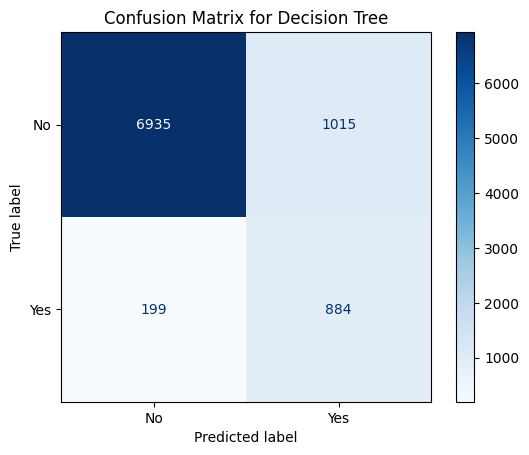


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.87      0.92      7950
           1       0.47      0.82      0.59      1083

    accuracy                           0.87      9033
   macro avg       0.72      0.84      0.76      9033
weighted avg       0.91      0.87      0.88      9033

Accuracy: 0.87
Precision: 0.47
Recall: 0.82
F1 Score: 0.59


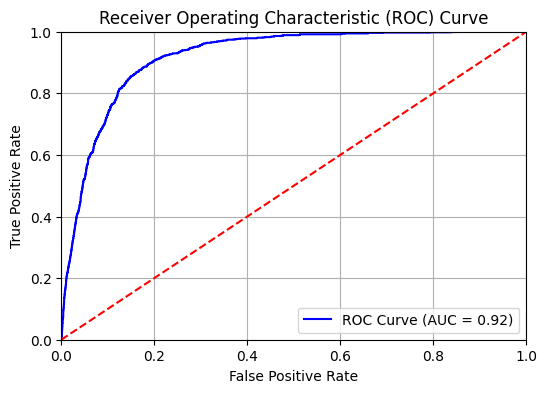

In [ ]:
# Model Evaluation
xgb_classifier = XGBClassifier(scale_pos_weight = 8.0, random_state=42)
xgb_classifier.fit(X_train_scaled, y_train)

y_pred_xgb = xgb_classifier.predict(X_test_scaled)

# Confusion Matrix
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
print("Confusion Matrix:")
print(conf_matrix_rf)

disp_xgb = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_xgb,
                                  display_labels=['No', 'Yes'])
disp_xgb.plot(cmap='Blues')
plt.title('Confusion Matrix for Decision Tree')
plt.show()

# Results
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_xgb):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_xgb):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred_xgb):.2f}")

plot_roc_curve(xgb_classifier, X_test_scaled, y_test)

In [ ]:
# Random Search

xgb_param_grid = {
    'n_estimators': [20, 50, 100],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
}

random_search_xgb = RandomizedSearchCV(xgb_classifier, xgb_param_grid, n_iter=5, cv=10, random_state=42, scoring='recall')
random_search_xgb.fit(X_train_scaled, y_train)

print("\nBest Parameters from RandomizedSearchCV:")
print(random_search_rf.best_params_)
print(f"Best Cross-Validation Score: {random_search_rf.best_score_:.2f}")


Best Parameters from RandomizedSearchCV:
{'n_estimators': 20, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 10, 'criterion': 'entropy'}
Best Cross-Validation Score: 0.84


In [ ]:
# Cross-Validation

best_xgb_classifier = random_search_xgb.best_estimator_
cv_scores = cross_val_score(best_xgb_classifier, X_train_scaled, y_train, cv=5, scoring='recall')

# Print cross-validation scores
print("Cross-Validation AUC Scores:", cv_scores)
print(f"Mean Cross-Validation AUC: {cv_scores.mean():.2f}")

Cross-Validation AUC Scores: [0.89060642 0.8549346  0.86801427 0.87619048 0.88703924]
Mean Cross-Validation AUC: 0.88


In [ ]:
# Feature Importance

xgb_importance_df = get_feature_importance(best_xgb_classifier, X_train.columns)
xgb_importance_df

,Feature,Importance
0,duration,0.215243
1,poutcome_success,0.192530
2,contact_unknown,0.146601
3,month_mar,0.093578
4,month_jul,0.077493
5,job_blue-collar,0.054383
6,month_oct,0.044302
7,month_jun,0.037920
8,month_feb,0.034437
9,age,0.033066


Вывод: В XGBoost:
*   Accuracy: 0.87
*   Precision: 0.47
*   Recall: 0.82
*   F1 Score: 0.59
*   по всем методам поиска гиперпараметров самый высокий cross validation  0.88

3.5 CatBoost

Learning rate set to 0.047658
0:	learn: 0.6644521	total: 134ms	remaining: 2m 13s
1:	learn: 0.6433856	total: 158ms	remaining: 1m 18s
2:	learn: 0.6208272	total: 168ms	remaining: 56s
3:	learn: 0.5998303	total: 182ms	remaining: 45.3s
4:	learn: 0.5831438	total: 193ms	remaining: 38.3s
5:	learn: 0.5645280	total: 208ms	remaining: 34.5s
6:	learn: 0.5523793	total: 219ms	remaining: 31.1s
7:	learn: 0.5411133	total: 229ms	remaining: 28.4s
8:	learn: 0.5303439	total: 242ms	remaining: 26.6s
9:	learn: 0.5183686	total: 254ms	remaining: 25.1s
10:	learn: 0.5078368	total: 264ms	remaining: 23.7s
11:	learn: 0.4989276	total: 275ms	remaining: 22.6s
12:	learn: 0.4913198	total: 285ms	remaining: 21.6s
13:	learn: 0.4852464	total: 304ms	remaining: 21.4s
14:	learn: 0.4791915	total: 316ms	remaining: 20.8s
15:	learn: 0.4729142	total: 328ms	remaining: 20.2s
16:	learn: 0.4666964	total: 338ms	remaining: 19.6s
17:	learn: 0.4606063	total: 349ms	remaining: 19s
18:	learn: 0.4530058	total: 359ms	remaining: 18.6s
19:	learn: 0.

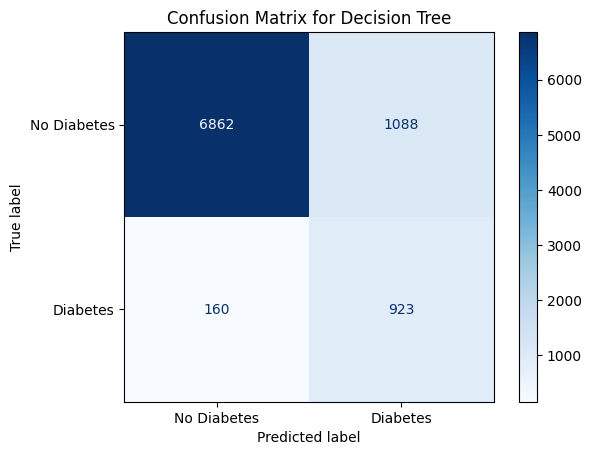


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.86      0.92      7950
           1       0.46      0.85      0.60      1083

    accuracy                           0.86      9033
   macro avg       0.72      0.86      0.76      9033
weighted avg       0.92      0.86      0.88      9033

Accuracy: 0.86
Precision: 0.46
Recall: 0.85
F1 Score: 0.60


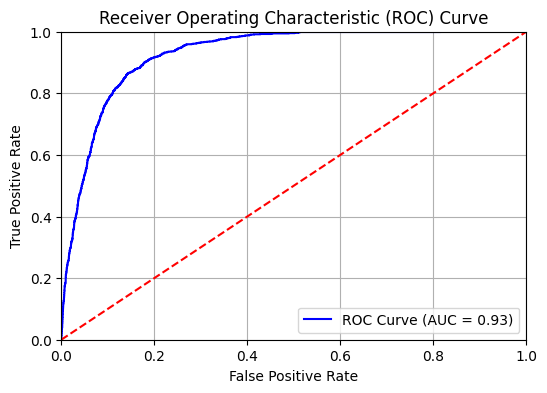

In [ ]:
# Model Evaluation

cb_classifier = CatBoostClassifier(scale_pos_weight = 8.0, random_state=42)
cb_classifier.fit(X_train_scaled, y_train)

y_pred_cb = cb_classifier.predict(X_test_scaled)

# Confusion Matrix
conf_matrix_cb = confusion_matrix(y_test, y_pred_cb)
print("Confusion Matrix:")
print(conf_matrix_cb)

disp_cb = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_cb,
                                  display_labels=['No Diabetes', 'Diabetes'])
disp_cb.plot(cmap='Blues')
plt.title('Confusion Matrix for Decision Tree')
plt.show()

# Results
print("\nClassification Report:")
print(classification_report(y_test, y_pred_cb))

print(f"Accuracy: {accuracy_score(y_test, y_pred_cb):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_cb):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_cb):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred_cb):.2f}")

plot_roc_curve(cb_classifier, X_test_scaled, y_test)

In [ ]:
# Random Search

cb_param_grid = {
    'iterations': [20, 50, 100],
    'depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5],
    'bagging_temperature': [0, 0.5, 1.0],
    'random_strength': [1, 2, 3]
}

random_search_cb = RandomizedSearchCV(cb_classifier, cb_param_grid, n_iter=8, cv=10, random_state=42, scoring='recall')
random_search_cb.fit(X_train_scaled, y_train)

print("\nBest Parameters from RandomizedSearchCV:")
print(random_search_cb.best_params_)
print(f"Best Cross-Validation Score: {random_search_cb.best_score_:.2f}")

0:	learn: 0.6378804	total: 55.5ms	remaining: 1.05s
1:	learn: 0.5997848	total: 85.2ms	remaining: 767ms
2:	learn: 0.5736446	total: 113ms	remaining: 642ms
3:	learn: 0.5465845	total: 139ms	remaining: 555ms
4:	learn: 0.5238883	total: 152ms	remaining: 456ms
5:	learn: 0.5102657	total: 189ms	remaining: 441ms
6:	learn: 0.4950151	total: 222ms	remaining: 412ms
7:	learn: 0.4797377	total: 249ms	remaining: 374ms
8:	learn: 0.4686144	total: 277ms	remaining: 339ms
9:	learn: 0.4573061	total: 310ms	remaining: 310ms
10:	learn: 0.4470482	total: 340ms	remaining: 278ms
11:	learn: 0.4404309	total: 372ms	remaining: 248ms
12:	learn: 0.4341624	total: 397ms	remaining: 214ms
13:	learn: 0.4267768	total: 420ms	remaining: 180ms
14:	learn: 0.4220753	total: 431ms	remaining: 144ms
15:	learn: 0.4179375	total: 441ms	remaining: 110ms
16:	learn: 0.4141143	total: 452ms	remaining: 79.7ms
17:	learn: 0.4108530	total: 464ms	remaining: 51.5ms
18:	learn: 0.4070809	total: 477ms	remaining: 25.1ms
19:	learn: 0.4043283	total: 506ms	re

In [ ]:
# Cross-Validation

best_cb_classifier = random_search_cb.best_estimator_
cv_scores = cross_val_score(best_cb_classifier, X_train_scaled, y_train, cv=5, scoring='recall')

# Print cross-validation scores
print("Cross-Validation AUC Scores:", cv_scores)
print(f"Mean Cross-Validation AUC: {cv_scores.mean():.2f}")

0:	learn: 0.6331561	total: 6.21ms	remaining: 615ms
1:	learn: 0.5778704	total: 14.3ms	remaining: 701ms
2:	learn: 0.5451055	total: 20.3ms	remaining: 657ms
3:	learn: 0.5222504	total: 26.2ms	remaining: 629ms
4:	learn: 0.5005725	total: 32.4ms	remaining: 616ms
5:	learn: 0.4848098	total: 38.6ms	remaining: 605ms
6:	learn: 0.4700278	total: 44.7ms	remaining: 593ms
7:	learn: 0.4619347	total: 50.3ms	remaining: 578ms
8:	learn: 0.4497099	total: 58ms	remaining: 586ms
9:	learn: 0.4430001	total: 64.1ms	remaining: 577ms
10:	learn: 0.4360368	total: 70.5ms	remaining: 571ms
11:	learn: 0.4293330	total: 76.9ms	remaining: 564ms
12:	learn: 0.4261854	total: 82.4ms	remaining: 551ms
13:	learn: 0.4229152	total: 88.4ms	remaining: 543ms
14:	learn: 0.4209306	total: 95.2ms	remaining: 540ms
15:	learn: 0.4177124	total: 101ms	remaining: 532ms
16:	learn: 0.4136003	total: 109ms	remaining: 530ms
17:	learn: 0.4107659	total: 115ms	remaining: 523ms
18:	learn: 0.4086411	total: 121ms	remaining: 517ms
19:	learn: 0.4066305	total: 

In [ ]:
# Feature Importance

cb_importance_df = get_feature_importance(best_cb_classifier, X_train.columns)
cb_importance_df

,Feature,Importance
0,duration,38.131139
1,contact_unknown,11.502855
2,poutcome_success,10.501497
3,day,7.745821
4,month_may,3.003797
5,month_nov,2.639590
6,age,2.624348
7,month_mar,2.522129
8,month_jul,2.355273
9,balance,2.338951


Вывод: В CatBoost:
*   Accuracy: 0.86
*   Precision: 0.46
*   Recall: 0.85
*   F1 Score: 0.60
*   по всем методам поиска гиперпараметров 0.88

4. Results comparison (Сравнение результатов)

Я бы выбрал Catboost как более точный  алгоритм, Так как основной параметр recall самый высокий, но и другие показатели тоже выше чем другие. по методамм поиска гиперпараметров показатель поднялся до 0.88, что является наивысшим чем в других алгоритмах.